In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
RND = 12345

In [2]:
arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

Так как у партий после 2499 известна только одна температура, мы уберем партии ниже 2500 (key)

In [3]:
temp =  temp.query('key < 2500')
arc = arc.query('key < 2500')
bulk = bulk.query('key < 2500')
wire = wire.query('key < 2500')

In [4]:
arc = arc[arc['Реактивная мощность'] > 0]
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])
arc['Продолжительность нагрева дугой в сек'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']) // pd.Timedelta('1s')
arc['Полная мощность'] = np.sqrt(arc['Активная мощность']**2 + arc['Реактивная мощность']**2)

In [5]:

arc_count = arc['key'].value_counts().sort_index().sort_index().reset_index()
arc_count = arc_count.rename(columns={'index': 'key',
                          'key': 'Количество запусков нагрева'})
arc = arc.groupby(by = 'key', as_index=False).sum()
arc = arc.merge(arc_count, how='left', on='key')

Проверим признаки на мультиколлинеарность

In [6]:
arc[['Активная мощность', 'Реактивная мощность',
       'Продолжительность нагрева дугой в сек', 'Полная мощность',
       'Количество запусков нагрева']].corr()

,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой в сек,Полная мощность,Количество запусков нагрева
Активная мощность,1.000000,0.959727,0.978192,0.993677,0.754205
Реактивная мощность,0.959727,1.000000,0.966462,0.985069,0.751501
Продолжительность нагрева дугой в сек,0.978192,0.966462,1.000000,0.982899,0.795958
Полная мощность,0.993677,0.985069,0.982899,1.000000,0.760402
Количество запусков нагрева,0.754205,0.751501,0.795958,0.760402,1.000000


Коррелируют такие столбцы как: Активная мощность и Реактивная мощность, Продолжительность нагрева дугой в сек и Полная мощность (Активная мощность и Реактивная мощность).

Их высокая корреляция может привести к переобучению моделей, так что их нужно убрать и оставить Полную мощность

In [7]:
arc = arc[['key', 'Полная мощность', 'Количество запусков нагрева']]

In [8]:
temp = temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
temp.columns = temp.columns.droplevel()
temp.columns = ['key', 'Замер 1', 'Замер 2', 'Температура 1', 'Температура 2']
temp = temp[['key', 'Температура 1', 'Температура 2']]

In [9]:
df = (arc.merge(temp, how='left', on='key')
         .merge(wire, how='left', on='key')
         .merge(bulk, how='left', on='key')
         .merge(gas, how='left', on='key'))

In [10]:
df = df.drop(['key'], axis = 1)
df = df.fillna(0)

In [11]:
df.columns

Index(['Полная мощность', 'Количество запусков нагрева', 'Температура 1',
       'Температура 2', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5',
       'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'Bulk 1', 'Bulk 2', 'Bulk 3',
       'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10',
       'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Газ 1'],
      dtype='object')

Разобьем данные на выборки

In [12]:
X, y = train_test_split(df, test_size = .25, random_state = RND)

X_train = X.drop(['Температура 2'], axis = 1)
y_train = X['Температура 2']

X_test = y.drop(['Температура 2'], axis = 1)
y_test = y['Температура 2']

Обучим модель случайного леса

In [13]:
%%time
param_rf_grid = {'n_estimators': [100, 300, 500], 
                 'max_depth': [2, 4, 6], 
                 'min_samples_split': [2, 5, 8], 
                 'max_features': ['auto', 'sqrt', 'log2', None],
#                'random_state' : [12345]
                }

grid_rf = GridSearchCV(RandomForestRegressor(random_state=RND), 
                       param_rf_grid, 
                       cv=5,
                       scoring='neg_mean_absolute_error')
grid_rf.fit(X_train, y_train)
params_rf = grid_rf.best_params_
rf = RandomForestRegressor(**params_rf, random_state=RND)
rf.fit(X_train, y_train)
pred_test = rf.predict(X_test)
print(params_rf)
print("MAE on test: ", mean_absolute_error(y_test, pred_test))

{'max_depth': 6, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
MAE on test:  6.712259319652873
CPU times: user 5min 57s, sys: 1.56 s, total: 5min 59s
Wall time: 6min


Получаем 6.71 MAE для модели предсказания температуры.

Text(0.5, 0, 'Random Forest feature importance')

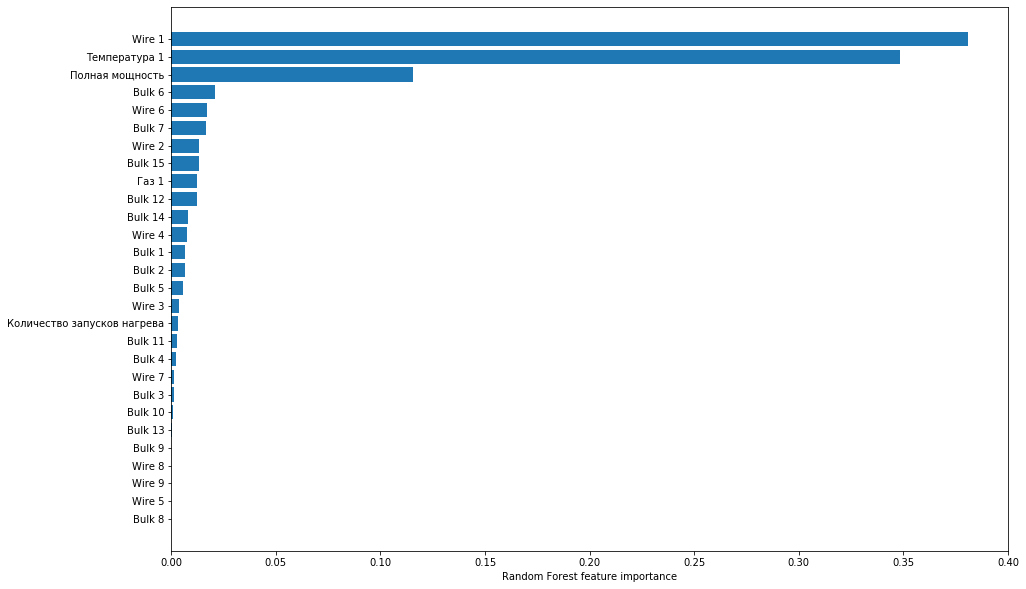

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_test.columns.values[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest feature importance")

Таким образом температура в основном зависит от проволочного материала, начальной температуры и полной мощности.